# Dynamic Regret Analysis

### Goal: Evaluate the regret decomposition provided in the paper.


$$
R_{T} \approx \underbrace{
    \frac{G^{2}}{\lambda} \cdot \ln{T}
}_{
    \text{static regret term}
} + \underbrace{
    GP_{T}
}_{
    \text{dynamic regret term}
}
$$

The main goal is to prove the regret decomposition provided in the paper. We demonstrate not only square-root growth of the regret curve, but break down that regret curve into static and dynamic components. If the theory is correct, the dynamic term should increase linearly in direct proportion to the strength of the stream's drift.

The configuration grid can be found below:

```yaml
# Regret Decomposition Grid Configuration
# This grid focuses on regret decomposition experiments with various parameter combinations
# to understand the impact of different settings on regret components.

matrix:
  # Core regret / capacity controls (reduced for manageable combinations)
  gamma_bar:       [1.0, 1.2]             # Total regret budget
  gamma_split:     [0.5, 0.6]             # Fraction allocated to insertions vs deletions
  
  # Privacy parameters
  eps_total:       [1.0, 2.0]             # Total epsilon budget
  delta_total:     [1e-5]                  # Total delta budget
  lambda_:          [0.1, 0.2]             # Strong convexity parameter
  delta_b:          [0.05, 0.1]            # Regret bound failure probability
  
  # Theory-first stream targets for regret decomposition
  target_G:         [2.0, 2.5]             # Gradient norm bound
  target_D:         [2.0, 2.5]             # Domain diameter
  target_c:         [0.05, 0.1]            # Lower curvature bound
  target_C:         [10.0, 20.0]           # Upper curvature bound
  target_lambda:    [0.05, 0.1]            # Theory strong convexity
  target_PT:         [30.0, 40.0]          # Total path length
  target_ST:         [100000.0, 200000.0]   # AdaGrad energy target
  
  # Stream configuration
  path_style:       ["rotating"]            # Path evolution style
  dim:              [20]                   # Dimensionality
  T:                [50000]                # Horizon
  accountant:       ["zcdp"]               # Privacy accountant
  comparator:       ["dynamic"]               # Comparator type
  
  # Algorithm settings
  algo:             ["memorypair"]         # Algorithm to use
  dataset:          ["synthetic"]          # Dataset type
  
  # Deletion parameters
  delete_ratio:     [5.0, 10.0]            # Inserts per delete
  max_events:       [10000]                # Maximum events
  
  # Regularization and stability
  lambda_reg:       [0.01, 0.05]          # L2 regularization
  m_max:            [8]                   # L-BFGS memory pairs
  eta_max:          [1.0]                  # Maximum step size
  adagrad_eps:      [1e-12]               # AdaGrad epsilon
  D_bound:          [2.0]                  # Diameter bound
  
  # Feature flags for regret decomposition analysis
  enable_oracle:    [true]                 # Enable oracle for regret decomposition
  drift_adaptation: [false]                # Disable drift adaptation for cleaner analysis
  
  # Output and logging
  seeds:            [42]                  # Random seed
  bootstrap_iters:  [500]                  # Bootstrap iterations
  output_granularity: ["seed"]             # Output granularity

# Optional: Include specific combinations for focused analysis
include:
  - where:
      gamma_bar: 1.0
      gamma_split: 0.6
      eps_total: 1.0
      target_G: 2.0
      target_D: 2.0
      enable_oracle: true
  - where:
      gamma_bar: 1.2
      gamma_split: 0.7
      eps_total: 2.0
      target_G: 2.5
      target_D: 2.5
      enable_oracle: true

# Limit total combinations for manageable execution
limit: 50
```

### Setup and data loading

The data from simulations is stored in parquet files for efficient memory storage. This allows us to query the data using SQL as we would in any relational database.

This notebook uses DuckDB to query Parquet event and grid datasets under 

This notebook uses DuckDB to query Parquet event datasets under `results_parquet/01_regret_decomposition/events/` and `results_parquet/01_regret_decomposition/grids` respectively. This infrastructure allows us to query without loading all the data into memory. If DuckDB isn't installed, please `pip install duckdb`.

In [1]:
from pathlib import Path
import duckdb
import json
import os
import sys
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# go up one level
os.chdir("..")

# project paths (edit if your repo layout differs)
REPO = Path(".").resolve()
RESULTS_GLOB = Path("results_parquet/1a_dynamic_regret_decomposition/events/grid_id=*/seed=*/*.parquet")  # corrected pattern
PARAMETERS_GLOB = Path("results_parquet/1a_dynamic_regret_decomposition/grids/")
DB_PATH = Path(REPO/"artifacts"/"star.duckdb")
DB_PATH.parent.mkdir(parents=True, exist_ok=True)

GRID_FILE = REPO/"grids/1a_dynamic_regret_decomposition.yaml"     # this notebook's grid
STAGING_TABLE = "staging.events"   # keep default from loader

In [2]:
from utils.duck_db_loader import load_star_schema, query_workload_regret_analysis

con = load_star_schema(
    input_path=str(RESULTS_GLOB),
    run_ddl=True,
    create_events_view=True,
    parameters_path=str(PARAMETERS_GLOB),
    memory_limit='500MB'
)
# Analyze workload vs total regret
analysis = query_workload_regret_analysis(con)
print(analysis[['grid_id', 'final_workload_avg_regret', 'final_total_avg_regret']])

DuckDB memory limit set to: 500MB
Found 250 files matching pattern: results_parquet/1a_dynamic_regret_decomposition/events/grid_id=*/seed=*/*.parquet
  f898f1111a034aaa84e60c6cfed9e809-0.parquet: 88 columns
  cc8972ef752045d9b2b15f2bb7c8c81c-0.parquet: 88 columns
  6c1e6c737f654177b3685bb0b4e35ef2-0.parquet: 88 columns
  1f8162dc75a14a16a6878e1ab03feb21-0.parquet: 88 columns
  e607753430494aaf98eaf82e047a281f-0.parquet: 88 columns
  1cab4ba5260d4012a6ff81e11327af39-0.parquet: 88 columns
  4541c2c00eca421fb6f0ba14e633a4df-0.parquet: 88 columns
  b334e49dd6b242439ec6c08737f1cdff-0.parquet: 88 columns
  d57a1da11ad54128913276bbbea506cd-0.parquet: 88 columns
  a50e2632099d46a8907b4e56a87d7068-0.parquet: 88 columns
  469bac998c2c4fc5bee42851d483301d-0.parquet: 88 columns
  8b7f62990ea54c8394df50c09332b476-0.parquet: 88 columns
  3840c3f775874fdca5566f11a8ffc269-0.parquet: 88 columns
  55e7fe8341ef49f18f645962f5ab1702-0.parquet: 88 columns
  5f0bf3f4d9d1418ca7265ab56d4e2093-0.parquet: 88 col

Creating fact table with 84 columns: ['grid_id', 'seed', 'event_id', 'op as event_type', 'c_hat', 'noise_regret_increment', 'drift_threshold', 'privacy_spend_running', 'oracle_w_norm', 'oracle_stalled_count', 'cum_regret_with_noise', 'P_T_true', 'cum_regret', 'C_hat_1', 'comparator_type', 'rho_remaining', 'sens_delete', 'oracle_refresh_step', 'sigma_step', 'rho_total', 'sample_id', 'eps_spent', 'drift_detected', 'P_T', 'accountant', 'stepsize_params', 'path_regret_increment', 'accountant_type', 'regret_dynamic', 'sc_active', 'acc', 'drift_episodes_count', 'oracle_objective', 'regret_path_term', 'avg_regret', 'static_regret_increment', 'eps_step_theory', 'event', 'regret_increment', 'PT_target_residual', 'ST_running', 'rho_step', 'sigma_delete', 'drift_flag', 'ST_target_residual', 'segment_id', 'rho_spent', 'x_norm', 'oracle_refreshes', 'delta_P', 'lambda_raw', 'g_norm', 'regret_static_term', 'm_used', 'regret', 'event_type', 'avg_regret_with_noise', 'lambda_est', 'noise_regret_cum', 'theory_targets', 'deletion_capacity', 'G_hat', 'base_eta_t', 'window_size', 'drift_boost_remaining', 'sc_stable', 'delta_step_theory', 'd_norm', 'P_T_est', 'N_gamma', 'w_star_norm', 'eps_remaining', 'capacity_remaining', 'sigma_step_theory', 'pair_damped', 'delta_total', 'pair_admitted', 'D_hat', 'stepsize_policy', 'S_scalar', 'noise', 'm_capacity', 'clip_applied', 'eta_t']


In [3]:
# Custom Color Palette Configuration
CUSTOM_PALETTE = {
    'aquamarine': '#b5ffe1',
    'celadon': '#93e5ab', 
    'mint': '#65b891',
    'dark_cyan': '#4e878c',
    'dark_green': '#00241b'
}

# Create a list of colors for easy use in plots
COLOR_SEQUENCE = [
    CUSTOM_PALETTE['aquamarine'],
    CUSTOM_PALETTE['celadon'],
    CUSTOM_PALETTE['mint'],
    CUSTOM_PALETTE['dark_cyan'],
    CUSTOM_PALETTE['dark_green']
]

# Configure matplotlib to use our custom color palette
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=COLOR_SEQUENCE)
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['axes.edgecolor'] = CUSTOM_PALETTE['dark_green']
plt.rcParams['axes.labelcolor'] = CUSTOM_PALETTE['dark_green']
plt.rcParams['text.color'] = CUSTOM_PALETTE['dark_green']
plt.rcParams['xtick.color'] = CUSTOM_PALETTE['dark_green']
plt.rcParams['ytick.color'] = CUSTOM_PALETTE['dark_green']
plt.style.use('dark_background')


# Configure seaborn to use our custom palette
sns.set_theme()
sns.set_palette(COLOR_SEQUENCE)
# Set seaborn style parameters to match our theme
sns.set_style("darkgrid", {
    'axes.edgecolor': CUSTOM_PALETTE['dark_green'],
    'axes.labelcolor': CUSTOM_PALETTE['dark_green'],
    'text.color': CUSTOM_PALETTE['dark_green'],
    'xtick.color': CUSTOM_PALETTE['dark_green'],
    'ytick.color': CUSTOM_PALETTE['dark_green'],
    'grid.color': CUSTOM_PALETTE['celadon'],
    'grid.alpha': 0.3
})


### Phases of the Experiment

The experiment proceeds in four distinct phases, each tied to the theoretical guarantees of the Memory Pair framework.


#### 1. Calibration

We first verify theoretical properties of the data stream using a constant 500 steps to measure stream properties. Constants such as the Lipschitz bound $G$, domain diameter $D$, and curvature spectrum $(c, C)$ are estimated to ensure the strong convexity assumption:

$$
f(y) \;\geq\; f(x) + \nabla f(x)^\top (y - x) + \frac{\lambda}{2}\|y - x\|^2.
$$

This ensures that regret bounds and capacity formulas derived later are valid.

---

#### 2. Warmup

During warmup, the learner collects enough samples to reach the **sample complexity threshold** $N_\gamma$. This is the minimum horizon such that the average regret drops below a target $\gamma$:

$$
\frac{1}{N} R_N \;\leq\; \gamma, \qquad 
R_N := \sum_{t=1}^N \bigl(\ell_t(w_t) - \ell_t(w^\star)\bigr).
$$

Only after $N_\gamma$ events does the deferred inference gate open, ensuring predictions are **PAC-competitive from the start**.

---

#### 3. Workload

In the workload phase, the model processes an interleaved stream of **insert** and **delete** events:
$$
E_t \in \{\text{insert}(x_t, y_t), \text{delete}(u_t)\}.
$$

- Insertions update the model via quasi-Newton (L-BFGS) steps.  
- Deletions trigger symmetric unlearning steps, consuming from the **deletion-capacity odometer**.

Dynamic regret is bounded by both a static term and a drift-dependent path-length term:

$$
R^{\text{dyn}}_T = O\!\left(\frac{G^2}{\lambda}\ln T \;+\; G P_T\right),
\quad
P_T = \sum_{t=2}^T \|w_t^\star - w_{t-1}^\star\|_2.
$$

---

#### 4. Finalization

At the conclusion of the workload, we finalize the **odometer** and check whether deletion capacity $m$ was respected:

$$
m \;\leq\; \frac{\gamma N - GD\sqrt{cC S_N}}{G \sigma_{\text{step}} \sqrt{2 \ln(1/\delta_B)}},
\quad
S_N = \sum_{t=1}^N \|g_t\|^2.
$$

If $m$ has been exhausted, the model must be retrained to preserve accuracy and fidelity guarantees.


### Analyzing the Distributions of Operation Counts Across Grid IDs

When I look at the graph above I notice an interesting trend. The sample complexities are largely consistent for many of the grid cells. Calibration is firmly set to 1500 steps and so this makes sense, but that isn't necessarily the case for other phases of the experiment.

The number of `warmup` steps falls into two regimes of almost discrete values. The same can be said of the `insert` and `delete` steps, as well. I wonder whether this would suggest a degree of consistency that isn't exactly intentional.

I'd like to see how consistent the parameters are across these cells. If the parameters for the sample complexity are exactly the same then I could understand some overlap in the values. Otherwise, I'm afraid we might be duplicating regret values. Or maybe some of the parameter variations aren't effective. I'd like to explore this further.

## Analyzing the Per-Seed Summary

There only appears to be one `grid_id` that was tested for this run of simulations.

I'm re-running the `grid_runner` command to produce a wider range of results. But if the results continue to write to a single grid_id partition, then I'll have to investigate the reason.

Seeds 0-3 have the same number of events.

Seeds 0-2 have the same number of insertions and deletions.

The `avg_regret` for seed 0 is much lower than the other seeds at ~0.0058, while seed 4 comes in next at 0.186.



all_events shape: (100000, 5)


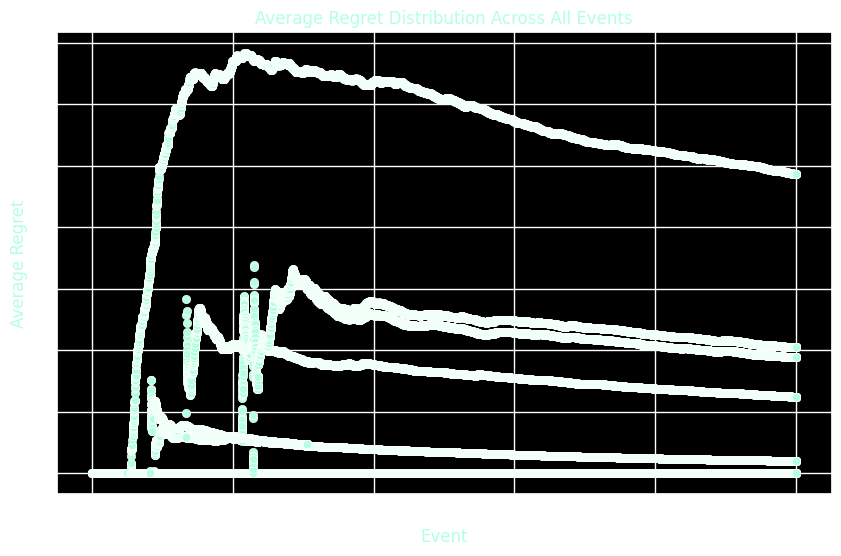

In [4]:
all_events = con.execute("SELECT grid_id, seed, event, workload_avg_regret, workload_cum_regret FROM analytics.v_events_workload WHERE is_workload_phase = TRUE LIMIT 100000").df()
print('all_events shape:', all_events.shape)
plt.figure(figsize=(10,6))
plt.style.use('dark_background')
sns.scatterplot(data=all_events, x='event', y='workload_avg_regret', alpha=1, color=CUSTOM_PALETTE['aquamarine'])
plt.title('Average Regret Distribution Across All Events', color=CUSTOM_PALETTE['aquamarine'])
plt.xlabel('Event', color=CUSTOM_PALETTE['aquamarine'])
plt.ylabel('Average Regret', color=CUSTOM_PALETTE['aquamarine'])
plt.show()

In [5]:
sample_grid_ids = con.execute('SELECT DISTINCT grid_id FROM analytics.v_events_workload LIMIT 5').df()['grid_id'].unique()
sample_grid_ids = set(sample_grid_ids)
print(sample_grid_ids)

{'a9472ad7dfce', '9b720d1be346', '5c87907593ab', '14e401030ba4', '51ffd09a297b'}


Grid ID: a9472ad7dfce, shape: (69650, 5)


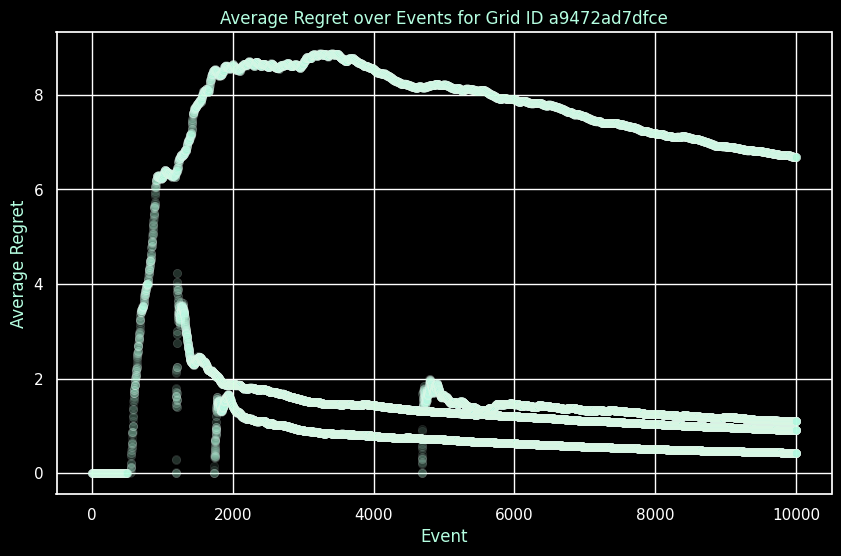

Grid ID: 9b720d1be346, shape: (69650, 5)


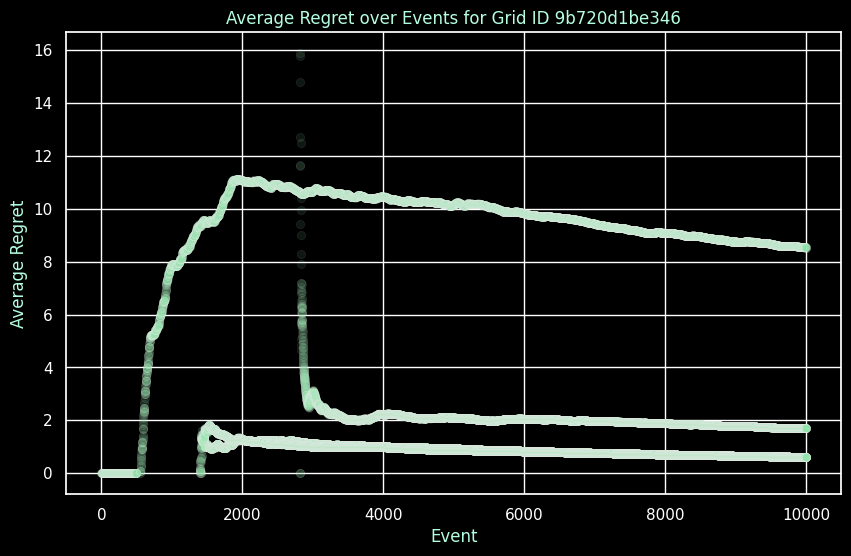

Grid ID: 5c87907593ab, shape: (69650, 5)


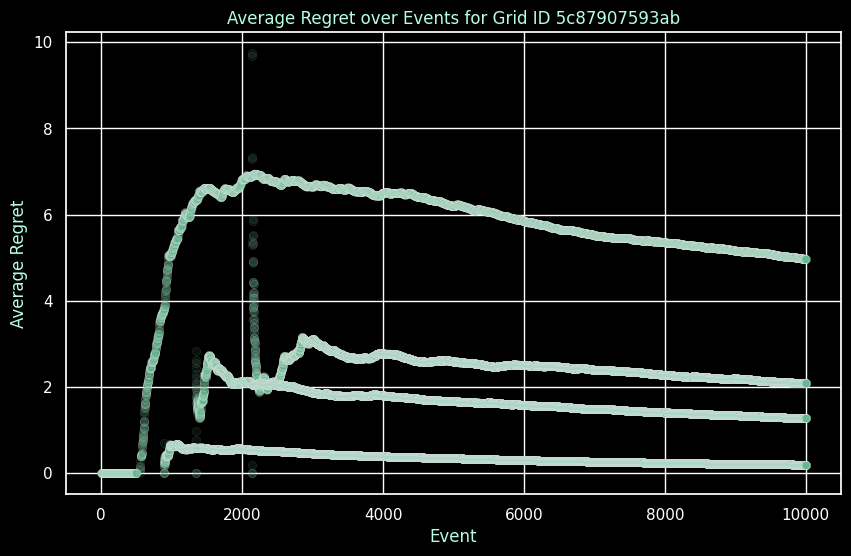

Grid ID: 14e401030ba4, shape: (69650, 5)


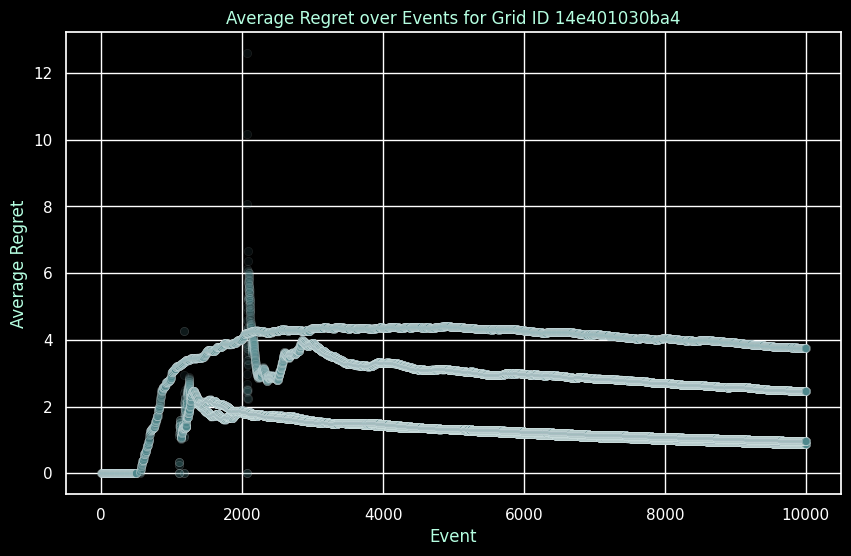

Grid ID: 51ffd09a297b, shape: (69650, 5)


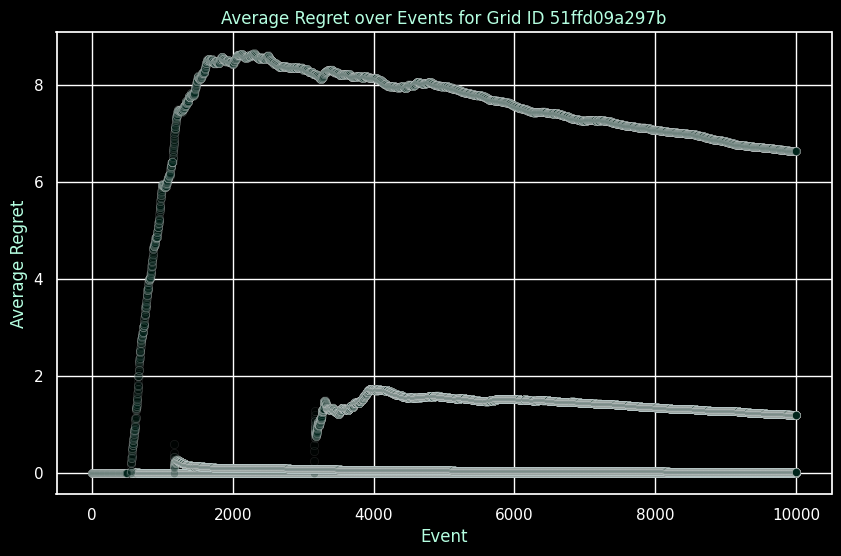

In [6]:
# plot one grid id per axis if regret and event columns exist
for i, gid in enumerate(sample_grid_ids):
    grid_events = con.execute("SELECT grid_id, seed, event, workload_avg_regret, workload_cum_regret FROM analytics.v_events_workload WHERE grid_id = '{}'".format(gid)).df()
    print(f'Grid ID: {gid}, shape: {grid_events.shape}')
    plt.figure(figsize=(10,6))
    plt.style.use('dark_background')
    sns.scatterplot(data=grid_events, x='event', y='workload_avg_regret', alpha=0.1, color=COLOR_SEQUENCE[i % len(COLOR_SEQUENCE)])
    plt.title(f'Average Regret over Events for Grid ID {gid}', color=CUSTOM_PALETTE['aquamarine'])
    plt.xlabel('Event', color=CUSTOM_PALETTE['aquamarine'])
    plt.ylabel('Average Regret', color=CUSTOM_PALETTE['aquamarine'])
    plt.show()


Grid ID: a9472ad7dfce, shape: (19900, 5)


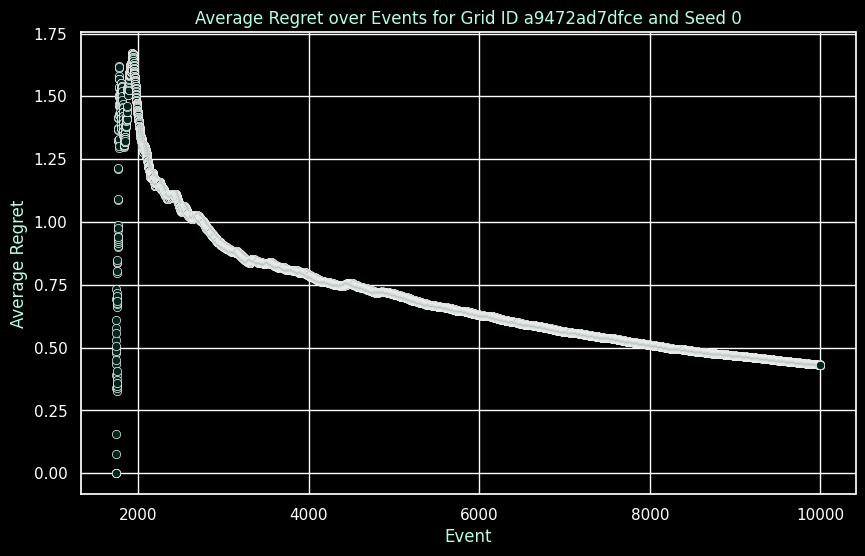

Grid ID: a9472ad7dfce, shape: (19900, 5)


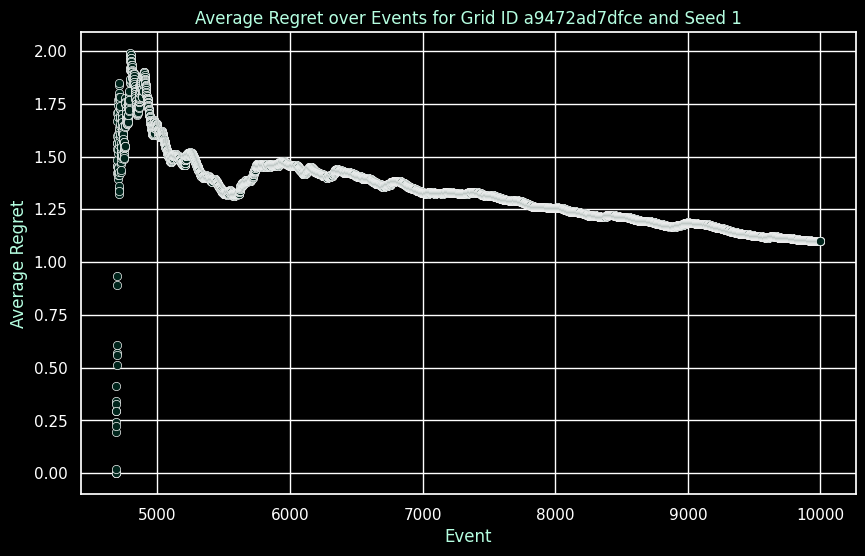

Grid ID: a9472ad7dfce, shape: (19900, 5)


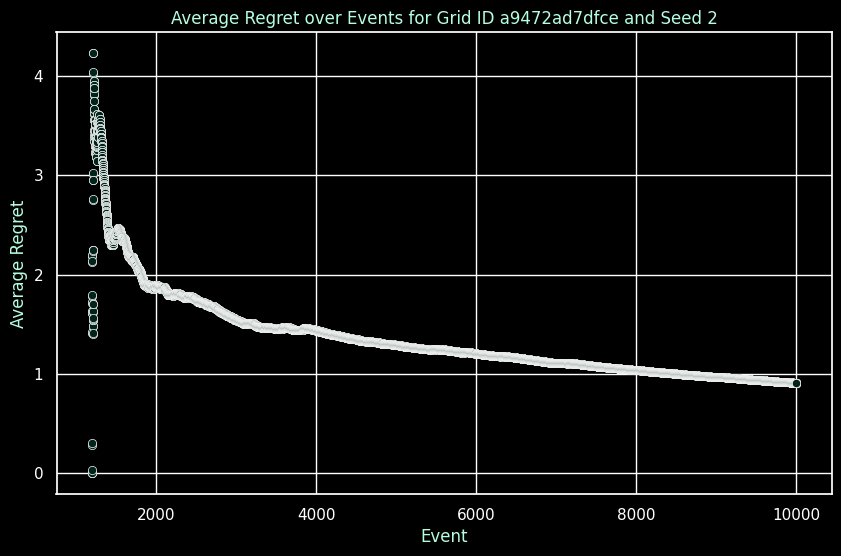

Grid ID: 9b720d1be346, shape: (19900, 5)


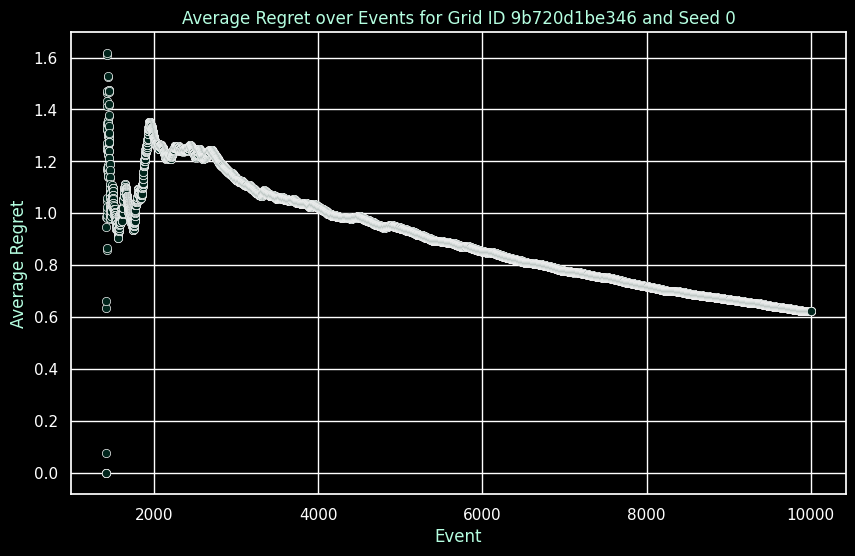

Grid ID: 9b720d1be346, shape: (19900, 5)


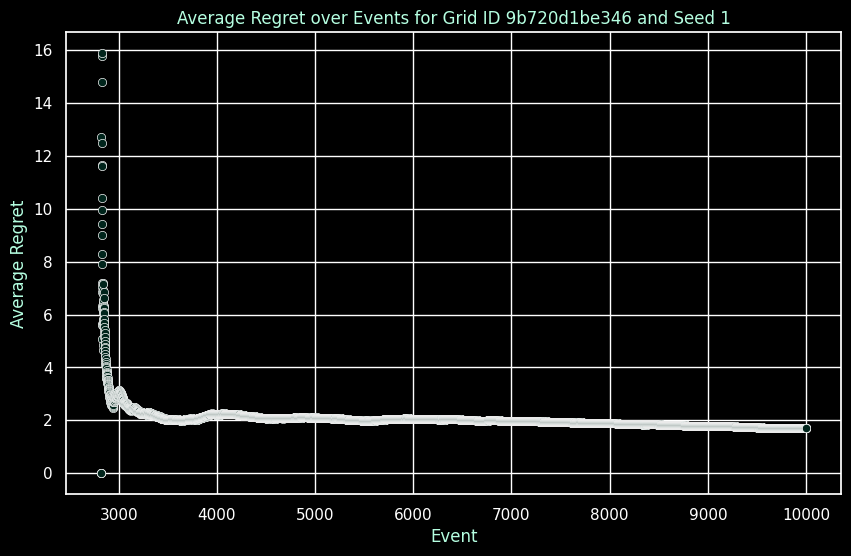

Grid ID: 9b720d1be346, shape: (19900, 5)


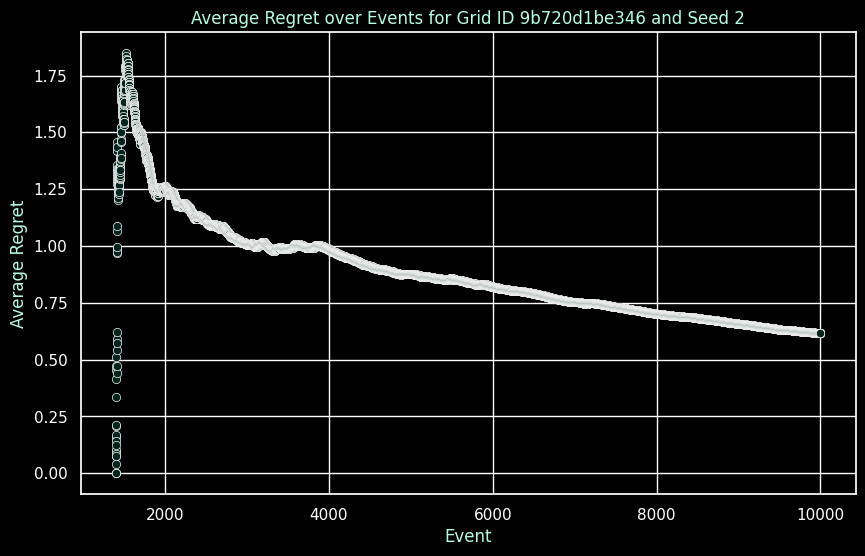

Grid ID: 5c87907593ab, shape: (19900, 5)


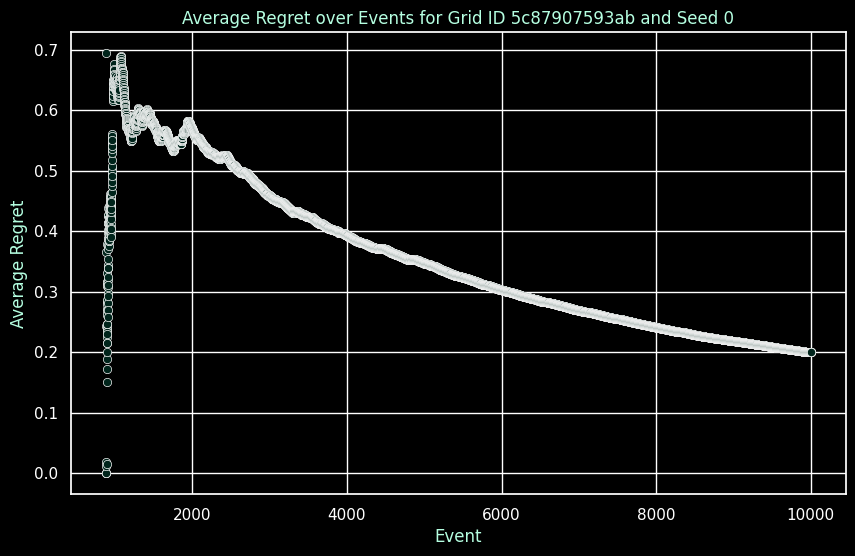

Grid ID: 5c87907593ab, shape: (19900, 5)


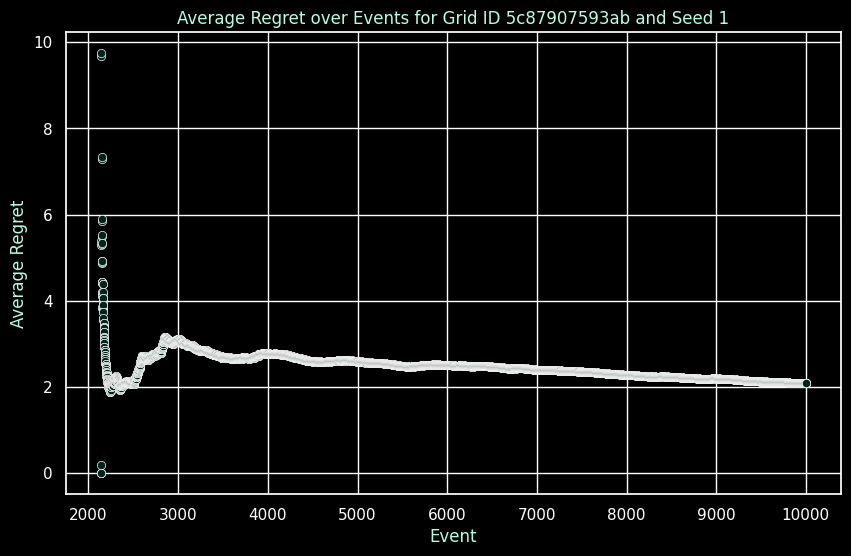

Grid ID: 5c87907593ab, shape: (19900, 5)


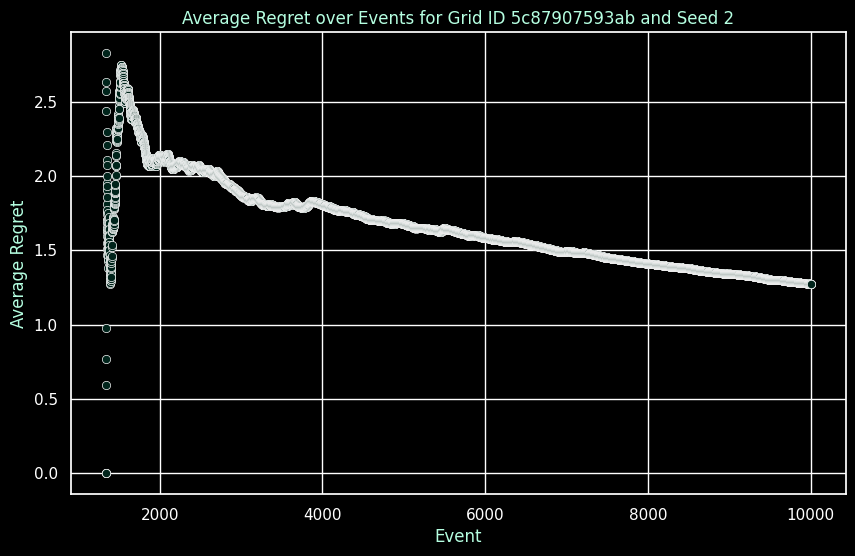

Grid ID: 14e401030ba4, shape: (19900, 5)


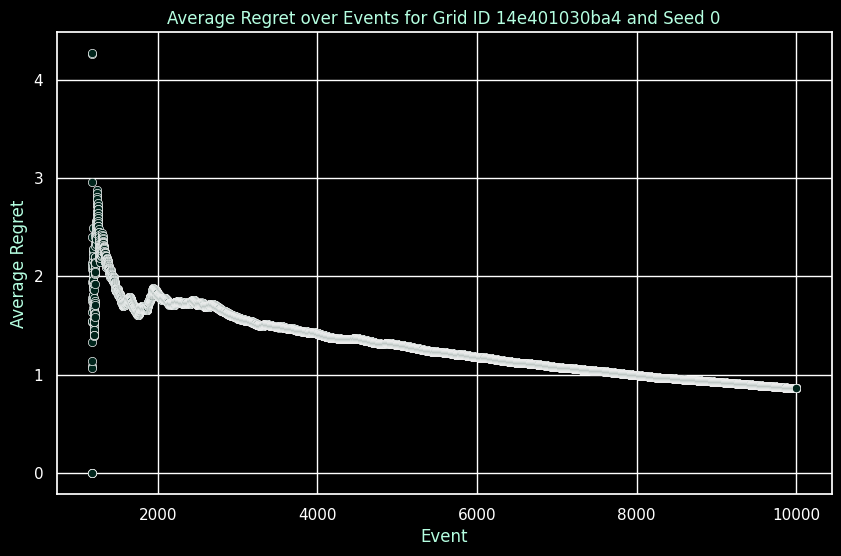

Grid ID: 14e401030ba4, shape: (19900, 5)


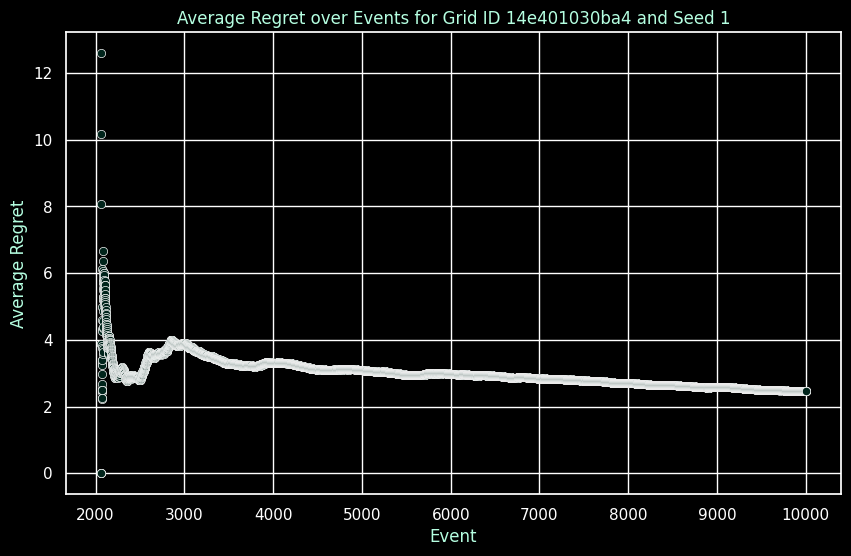

Grid ID: 14e401030ba4, shape: (19900, 5)


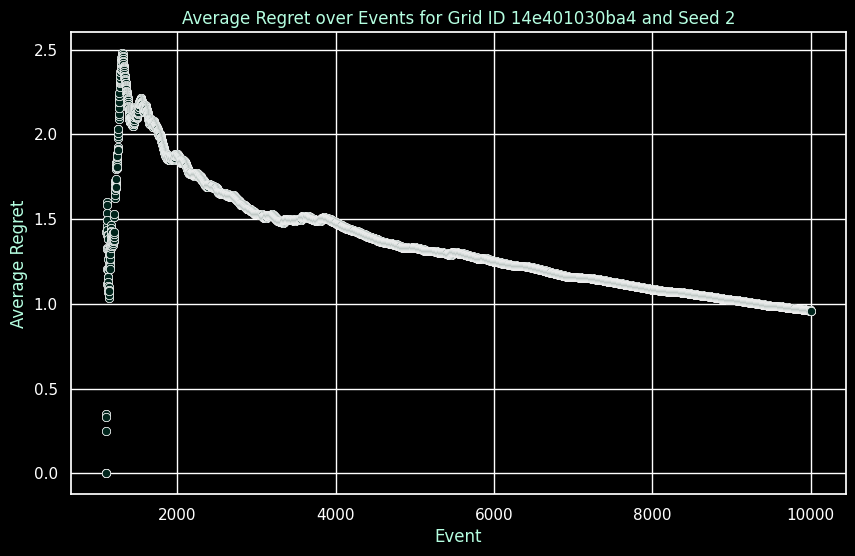

Grid ID: 51ffd09a297b, shape: (19900, 5)


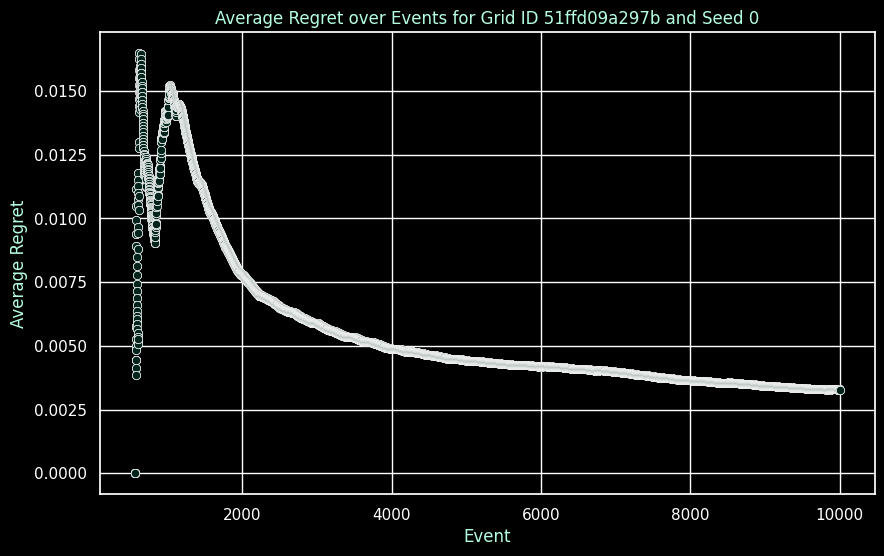

Grid ID: 51ffd09a297b, shape: (19900, 5)


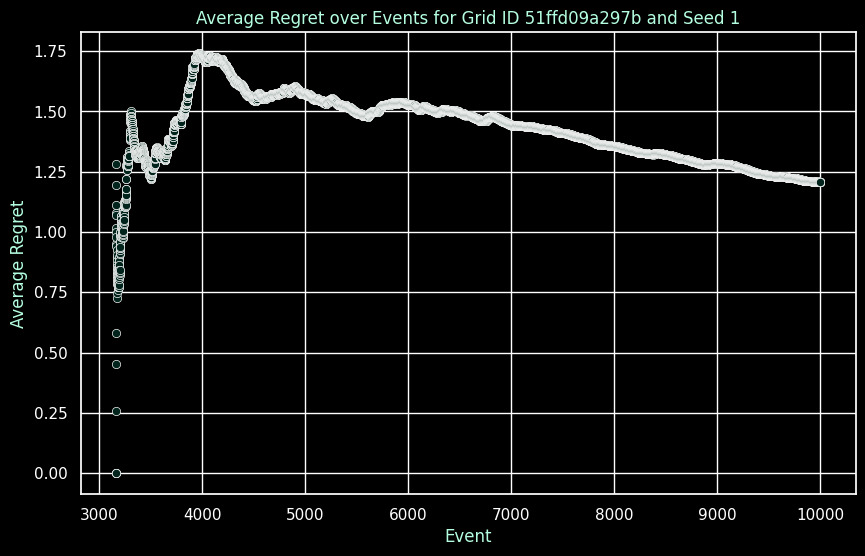

Grid ID: 51ffd09a297b, shape: (19900, 5)


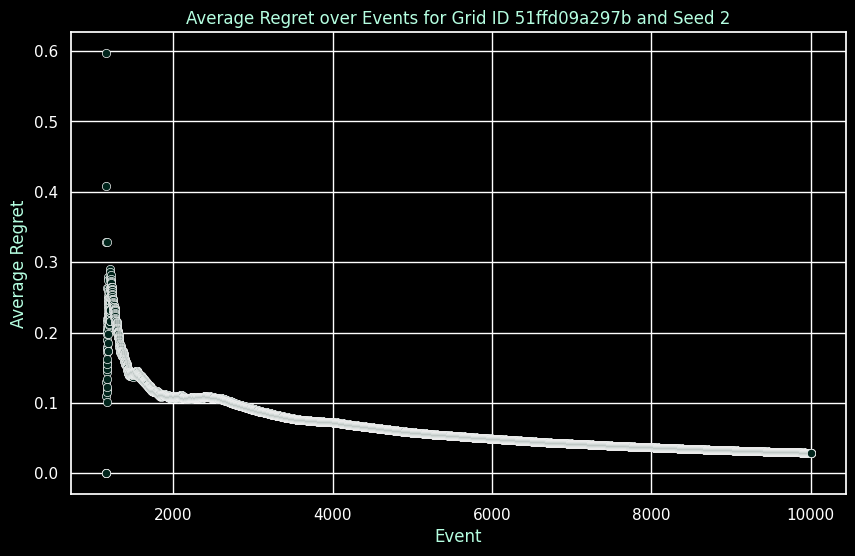

In [7]:
# plot one grid id x seed per axis if regret and event columns exist with overlays for op type
# with only a sample of N = 1000 points per grid_id for clarity
sample_seeds = range(3)
for gid in sample_grid_ids:
    for seed in sample_seeds:
        # plot one grid id per axis if regret and event columns exist
        grid_events = con.execute("SELECT grid_id, seed, event, workload_avg_regret, workload_cum_regret FROM analytics.v_events_workload WHERE grid_id = '{}' and seed = '{}'".format(gid, seed)).df()
        print(f'Grid ID: {gid}, shape: {grid_events.shape}')
        plt.figure(figsize=(10,6))
        plt.style.use('dark_background')
        sns.scatterplot(data=grid_events, x='event', y='workload_avg_regret', alpha=1, color=COLOR_SEQUENCE[i % len(COLOR_SEQUENCE)])
        plt.title(f'Average Regret over Events for Grid ID {gid} and Seed {seed}', color=CUSTOM_PALETTE['aquamarine'])
        plt.xlabel('Event', color=CUSTOM_PALETTE['aquamarine'])
        plt.ylabel('Average Regret', color=CUSTOM_PALETTE['aquamarine'])
        plt.show()



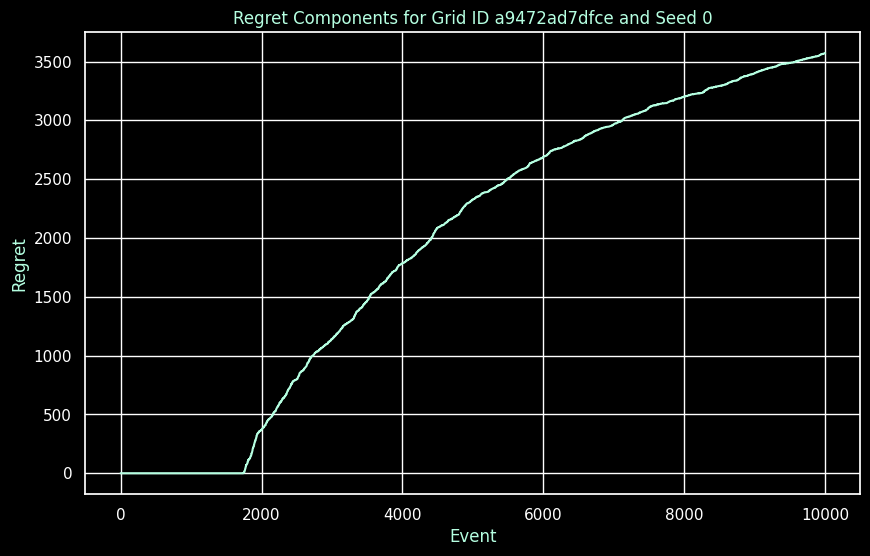

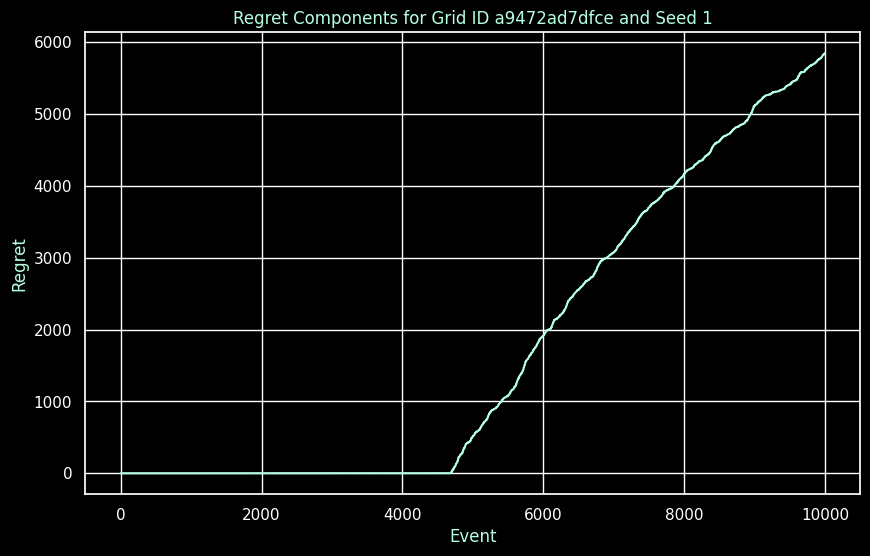

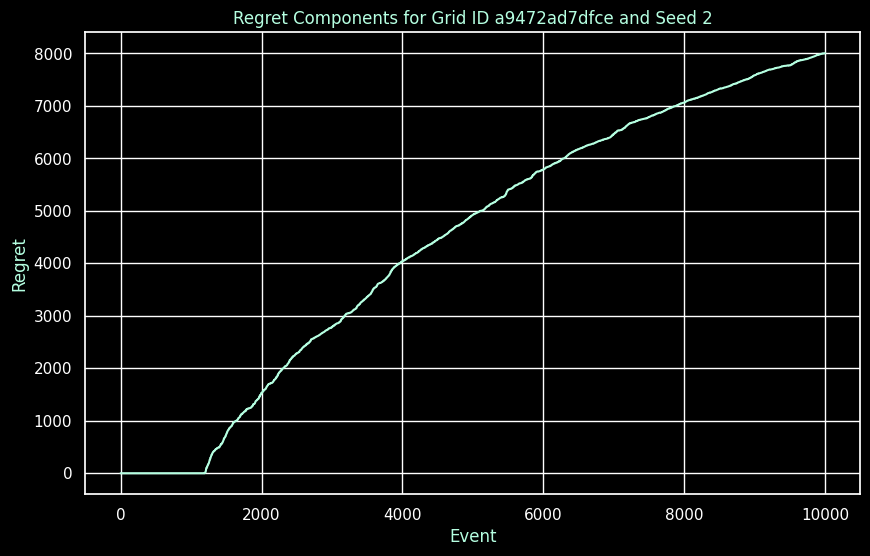

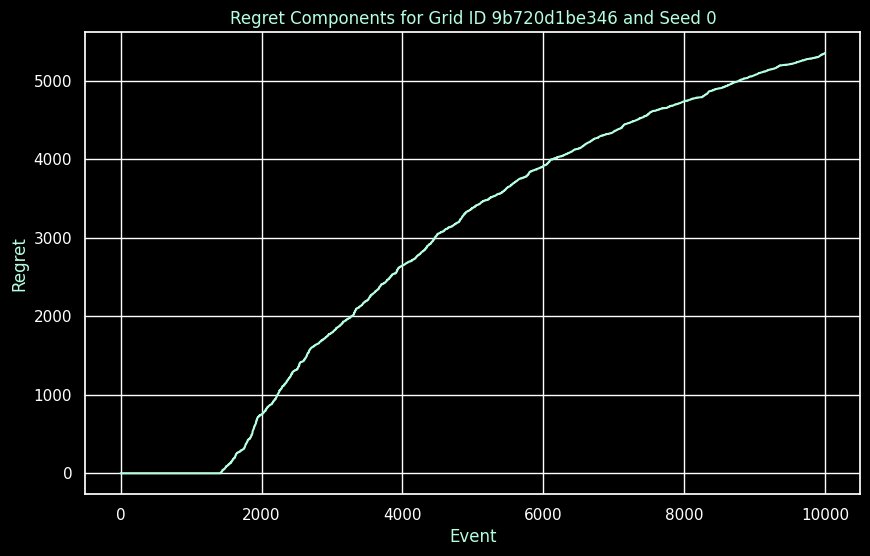

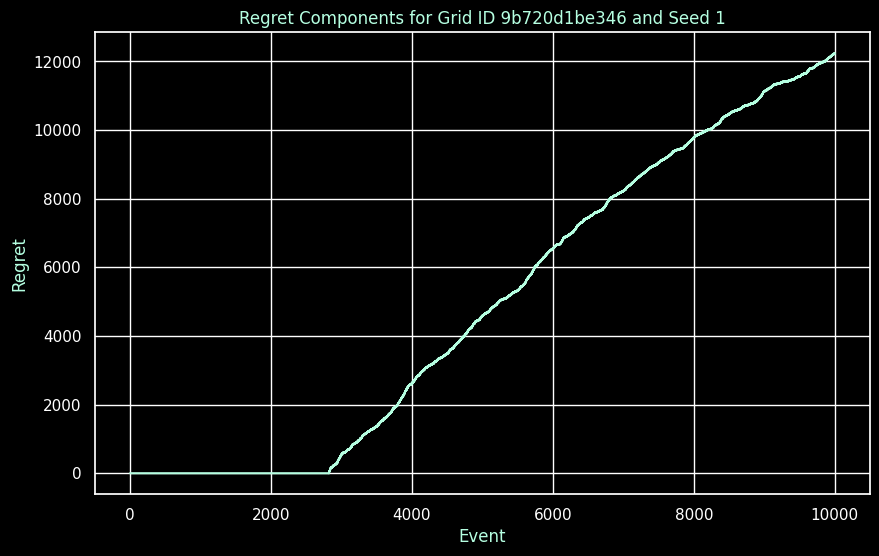

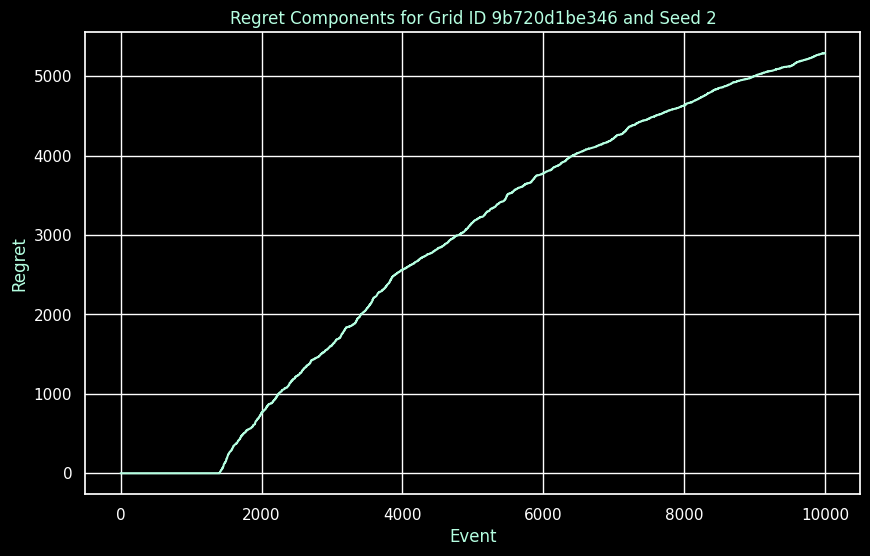

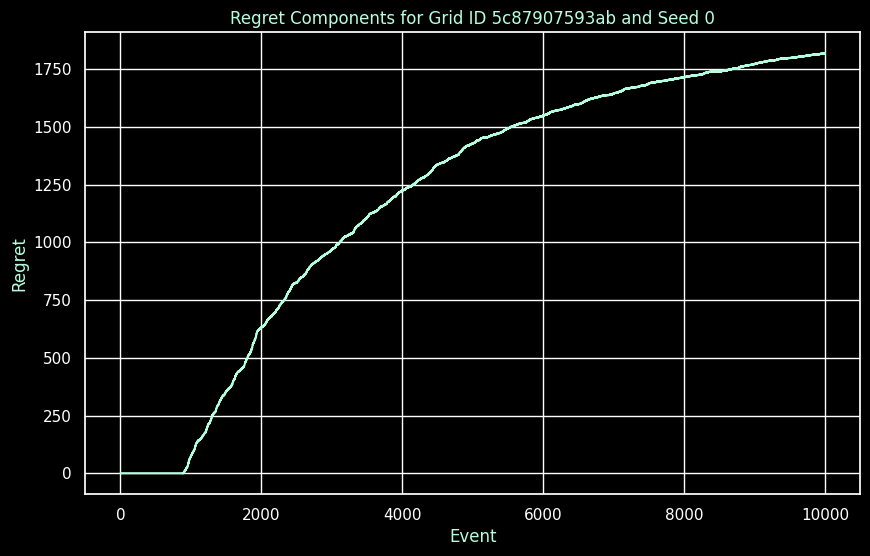

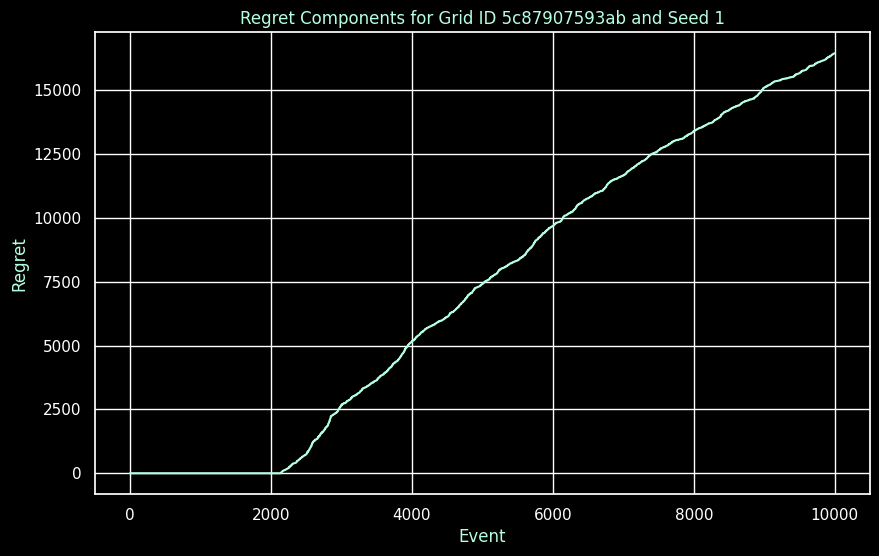

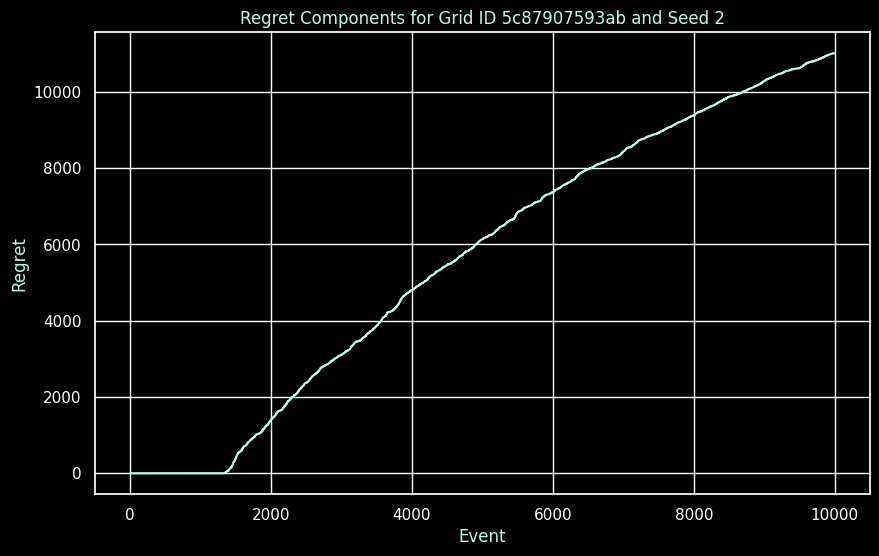

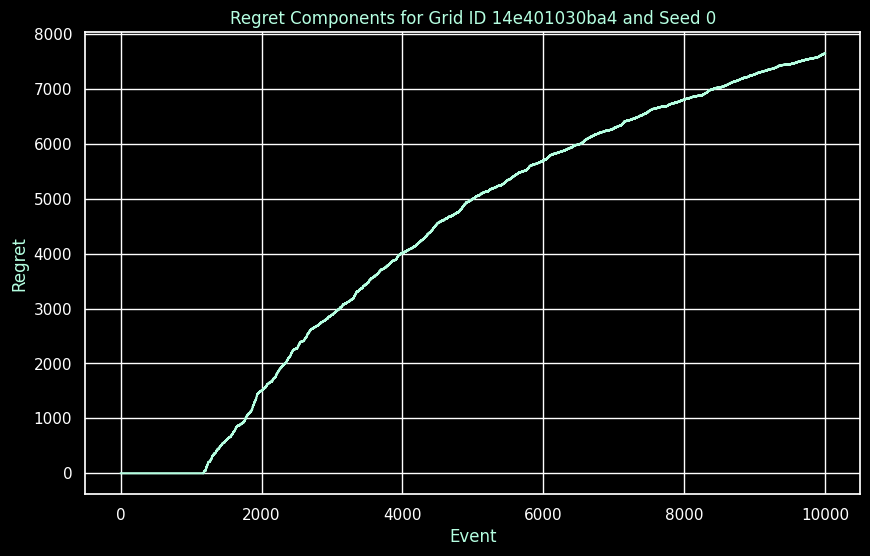

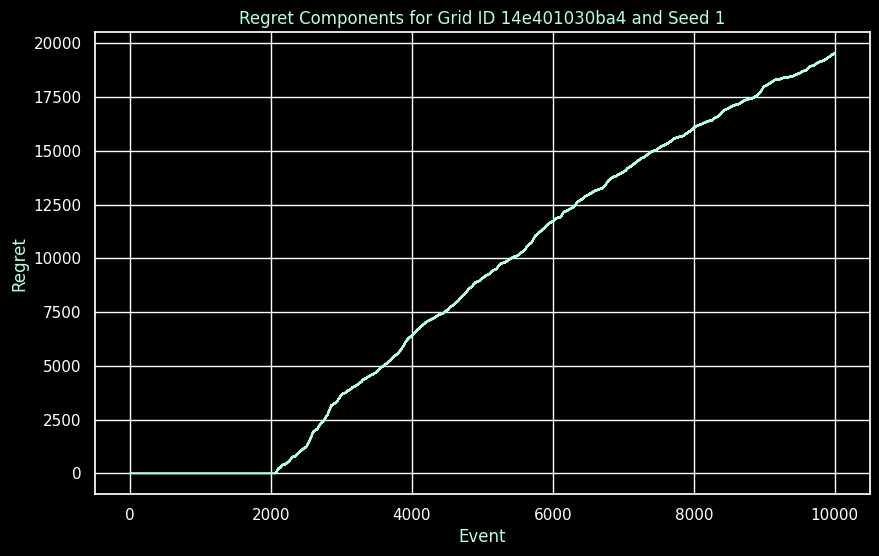

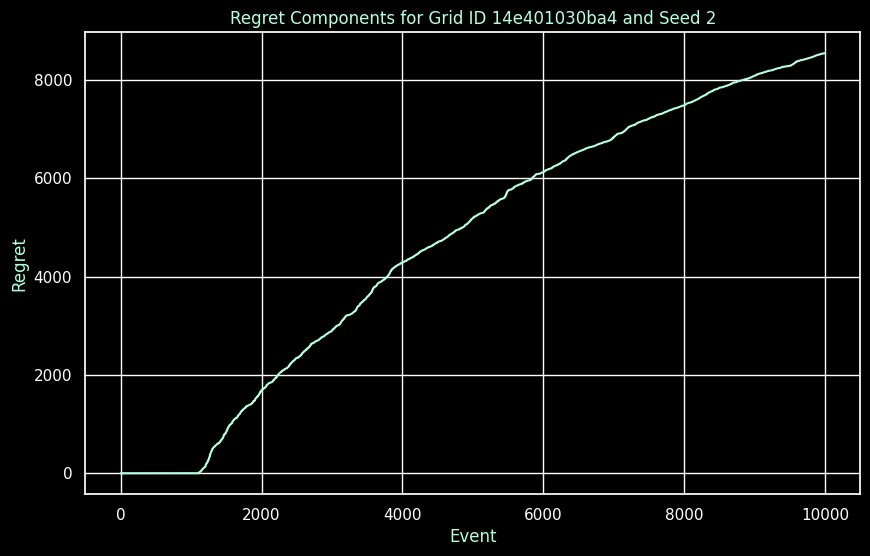

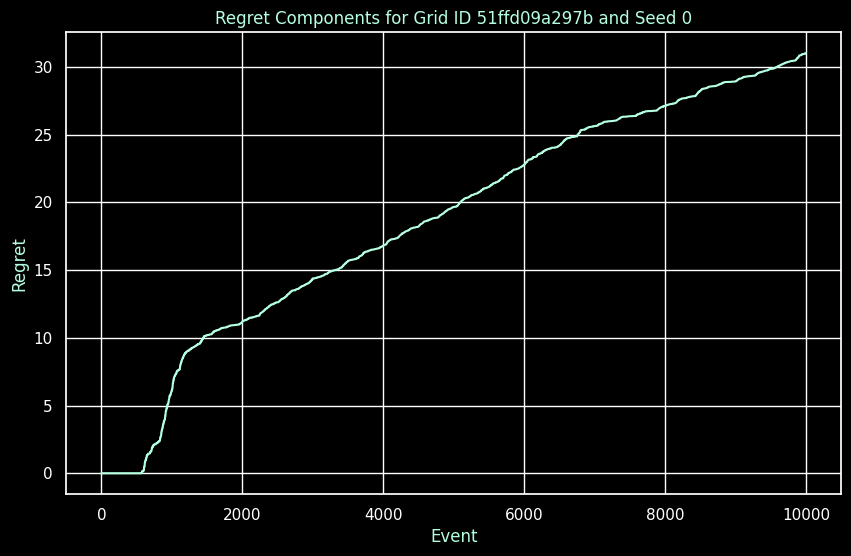

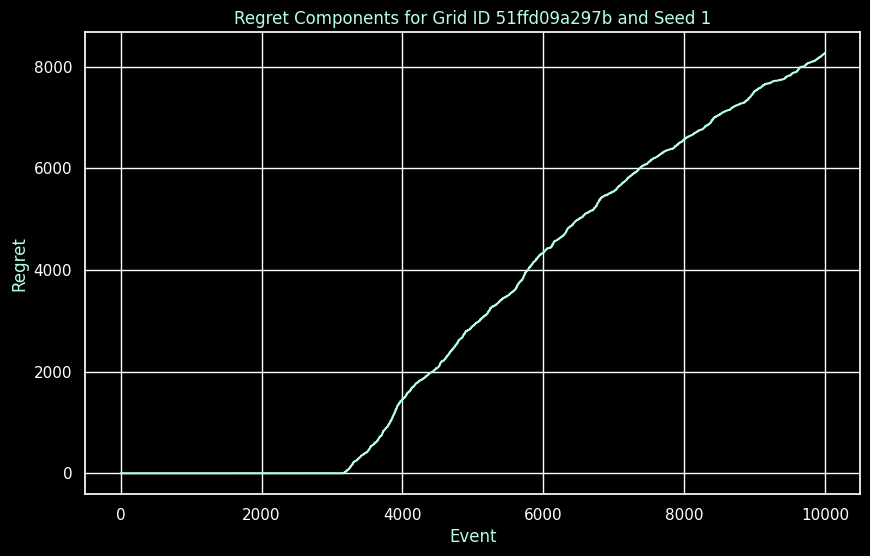

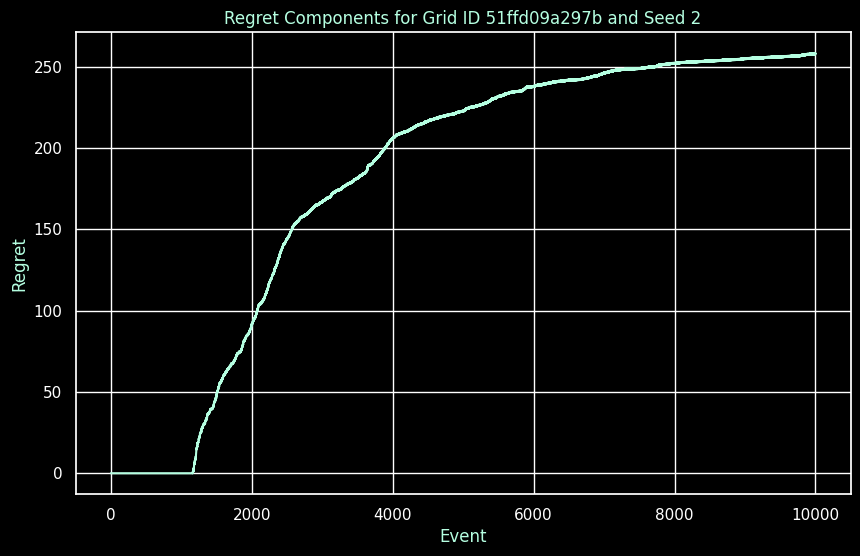

In [8]:
# plot one grid id x seed per axis if regret and event columns exist with overlays for op type
# with only a sample of N = 1000 points per grid_id for clarity
sample_seeds = range(3)
for gid in sample_grid_ids:
    for seed in sample_seeds:
        deletion_event = con.execute(f"SELECT MIN(event) FROM analytics.v_events_workload WHERE grid_id = '{gid}' AND seed = '{seed}' AND event_type = 'delete'")
        grid_events = con.execute("SELECT grid_id, seed, event, workload_avg_regret, workload_cum_regret FROM analytics.v_events_workload WHERE grid_id = '{}' AND seed = '{}'".format(gid, seed)).df()
        # find the first deletion event
        plt.figure(figsize=(10,6))
        plt.style.use('dark_background')
        plt.plot(grid_events['event'], grid_events['workload_cum_regret'], label='Workload Cumulative Regret', color=CUSTOM_PALETTE['aquamarine'])
        deletion_event = deletion_event.fetchone()
        if deletion_event:
            deletion_event = deletion_event[0]
            print(f'Deletion event: {deletion_event}')
            plt.axvline(x=deletion_event, color='red', linestyle='--', label='deletion event')
        plt.title(f'Regret Components for Grid ID {gid} and Seed {seed}', color=CUSTOM_PALETTE['aquamarine'])
        plt.xlabel('Event', color=CUSTOM_PALETTE['aquamarine'])
        plt.ylabel('Regret', color=CUSTOM_PALETTE['aquamarine'])
        plt.show()
